In [1]:
# all the imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from tensorflow.python.layers import core as core_layers
import pandas as pd
from datetime import datetime
import pytz
import pandas_datareader.data as web
from sklearn import metrics
ops.reset_default_graph()
tf.set_random_seed(654)

# Part I :  synthetic stock return data with one market factor and auto-regressive residuals 

## parameters

In [2]:
# N stocks for T times, p factors
N=100
T=300
p=1

In [3]:
# from residual U to calculate back b_estimate
def calculate_b (u):
    b = np.zeros(N)
    for i in range(N):
        uu = u[:,i]
        UU1 = uu[:-1]*uu[1:]
        UU2 = uu**2
        b[i] = np.average(UU1)/np.average(UU2)
    return b

## Linear regression

In [4]:
# input is an original b, and output is b_estimate
def linear_regression(b=0.5):
    A=np.identity(N)
    B=np.zeros((T,T))
    F = np.zeros((p,T))
    L = np.zeros((N,p))
    # to generate L,F,U,R
    for i in range(T):
        for j in range(T):
            B[i,j]=b**(abs(i-j))
    epsilon = np.zeros((N,T))
    for i in range(N):
        for j in range(T):
            epsilon[i,j]=np.random.normal()
    U=A.dot(epsilon.dot(scipy.linalg.sqrtm(B))).T
    for i in range(T):
        F[0,i]=np.random.normal()
    for i in range(N):
        L[i,0]=np.random.normal()
    F=F.T
    L=L.T
    R=F.dot(L)+U
    # linear regression coefficients
    theta_L = 1/F.T.dot(F)[0,0]*F.T.dot(R)
    # recalculate residual matrix U
    u_linear = R-F.dot(theta_L)
    b_linear = calculate_b(u_linear)
    # return the average b_estimate for N stocks
    return np.average(b_linear)

In [7]:
# bs is original parameter b, and b_estimate is corresponding estimated b
bs = np.linspace(0,1,101)
b_estimate_linear = np.zeros(len(bs))
for i in range(len(bs)):
    print(i,end = " ")
    b_estimate_linear[i] = linear_regression(bs[i])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: ComplexWarning: Casting complex values to real discards the imaginary part


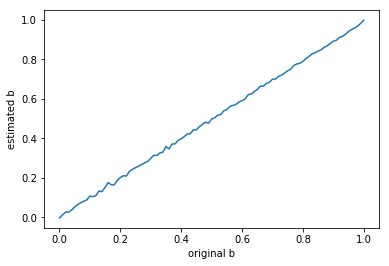

In [9]:
plt.plot(bs,b_estimate_linear)
plt.xlabel("original b")
plt.ylabel("estimated b")
plt.title("b estimate of Linear Regression")
plt.show()

In [10]:
error_linear = np.average((bs-b_estimate_linear)**2)

In [11]:
error_linear

4.9846010106653026e-05

## PCA

In [12]:
def pca(b=0.5):
    A=np.identity(N)
    B=np.zeros((T,T))
    F = np.zeros((p,T))
    L = np.zeros((N,p))
    for i in range(T):
        for j in range(T):
            B[i,j]=b**(abs(i-j))
    epsilon = np.zeros((N,T))
    for i in range(N):
        for j in range(T):
            epsilon[i,j]=np.random.normal()
    U=A.dot(epsilon.dot(scipy.linalg.sqrtm(B))).T
    for i in range(T):
        F[0,i]=np.random.normal()
    for i in range(N):
        L[i,0]=np.random.normal()
    F=F.T
    L=L.T
    R=F.dot(L)+U
    # we calculate covariance matrix of return, and extract first p eigvalues/eigvectors
    cov=np.cov(R.T)
    eig=np.linalg.eig(cov)
    eigvalue_first = eig[0][:p]
    eigvector_first = eig[1][:p].T
    # residual matrix
    X=R.dot(eigvector_first)
    u_pca = R-X.dot(L)
    b_pca = calculate_b(u_pca)
    return np.average(b_pca)

In [13]:
b_estimate_pca = np.zeros(len(bs))
for i in range(len(bs)):
    print(i,end = " ")
    b_estimate_pca[i] = pca(bs[i])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: ComplexWarning: Casting complex values to real discards the imaginary part


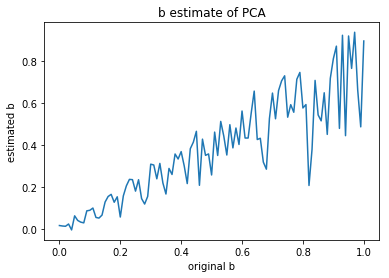

In [14]:
plt.plot(bs,b_estimate_pca)
plt.xlabel("original b")
plt.ylabel("estimated b")
plt.title("b estimate of PCA")
plt.show()

In [15]:
error_pca = np.average((bs-b_estimate_pca)**2)

In [16]:
error_pca

0.032230035885051224

## neural network

In [27]:
class NN_Model:
    def __init__(self, n_input, n_output, hidden_layer_shapes=[32], 
                 activation=tf.nn.relu, optimizer = tf.train.GradientDescentOptimizer,learning_rate=0.01):
        
        self.x = tf.placeholder(tf.float32, shape=(None, n_input), name="X")
        self.y = tf.placeholder(tf.float32, shape=(None, n_output), name="y")
        
        # include the output layer in the list of layers
        hidden_layer_shapes_full = hidden_layer_shapes + [n_output]

        previous_layer_output = self.x
        previous_layer_size = n_input
        
        # define all layers
        for i in range(0, len(hidden_layer_shapes_full)):
            if i < (len(hidden_layer_shapes_full) - 1):
                # inner (hidden) layer
                hidden_layer = core_layers.Dense(hidden_layer_shapes_full[i], activation=activation)   
            else:
                # output layer
                hidden_layer = core_layers.Dense(hidden_layer_shapes_full[i])
                
            hidden_layer.build([None, previous_layer_size])
            
            # output of a hidden layer is an iput to the next layer
            previous_layer_output = hidden_layer(previous_layer_output)
            
            # also redefine the size of the previous layer as the size of the current layer 
            previous_layer_size = hidden_layer_shapes_full[i]
        
        # define loss and train_op, and would return output
        self.loss = tf.reduce_mean(tf.square(previous_layer_output - self.y))
        self.train_op = optimizer(learning_rate).minimize(self.loss)
        self.output = previous_layer_output

In [17]:
def NN(b=0.5):
    # same methods of generating number
    A=np.identity(N)
    B=np.zeros((T,T))
    F = np.zeros((p,T))
    L = np.zeros((N,p))
    for i in range(T):
        for j in range(T):
            B[i,j]=b**(abs(i-j))
    epsilon = np.zeros((N,T))
    for i in range(N):
        for j in range(T):
            epsilon[i,j]=np.random.normal()
    U=A.dot(epsilon.dot(scipy.linalg.sqrtm(B))).T
    for i in range(T):
        F[0,i]=np.random.normal()
    for i in range(N):
        L[i,0]=np.random.normal()
    F=F.T
    L=L.T
    R=F.dot(L)+U
    # put F and R into neural network to regress L and obtain U
    model = NN_Model(n_input=F.shape[1],n_output = R.shape[1],hidden_layer_shapes=[10])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # we iterate it for 1000 times
        for i in range(1000):
            _= sess.run(model.train_op, feed_dict={model.x:F,model.y:R})
            output = sess.run(model.output,feed_dict={model.x:F,model.y:R})
        u_temp = R-output
        b_temp = calculate_b(u_temp)
        return np.average(b_temp)

In [19]:
b_estimate_NN = np.zeros(len(bs))
for i in range(len(bs)):
    print(i,end = " ")
    b_estimate_NN[i] = NN(bs[i])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: ComplexWarning: Casting complex values to real discards the imaginary part


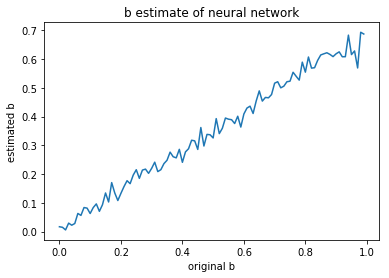

In [20]:
plt.plot(bs[:-1],b_estimate_NN[:-1])
plt.xlabel("original b")
plt.ylabel("estimated b")
plt.title("b estimate of neural network")
plt.show()

In [21]:
error_NN = np.average((bs[:-1]-b_estimate_NN[:-1])**2)

In [22]:
error_NN

0.031194395041055735

## all figures

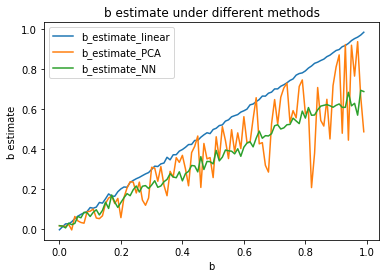

In [23]:
# we plot b_estimate together
plt.plot(bs[:-1],b_estimate_linear[:-1])
plt.plot(bs[:-1],b_estimate_pca[:-1])
plt.plot(bs[:-1],b_estimate_NN[:-1])
plt.legend(("b_estimate_linear","b_estimate_PCA","b_estimate_NN"))
plt.xlabel("b")
plt.ylabel("b estimate")
plt.title("b estimate under different methods")
plt.show()

# Part II: synthetic stock return data with 50 market factor and auto-regressive residuals to compare neural network and autoencoder

## neural network

In [24]:
N=1
T=3000
p=50
b=0.5

In [25]:
# same way to generate data
A=np.identity(N)
B=np.zeros((T,T))
F = np.zeros((p,T))
L = np.zeros((N,p))
for i in range(T):
    for j in range(T):
        B[i,j]=b**(abs(i-j))
epsilon = np.zeros((N,T))
for i in range(N):
    for j in range(T):
        epsilon[i,j]=np.random.normal()
U=A.dot(epsilon.dot(scipy.linalg.sqrtm(B))).T
for i in range(T):
    F[0,i]=np.random.normal()
for i in range(N):
    L[i,0]=np.random.normal()
F=F.T
L=L.T
R=F.dot(L)+U

In [26]:
# here we only want to compare neural network and autoencoder, so we only make a 
n_train = int(T*3/4)
F_train = F[:n_train]
R_train = R[:n_train]
F_test = F[n_train:]
R_test = R[n_train:]

In [28]:
model_nn = NN_Model(n_input=F.shape[1],n_output = R.shape[1],hidden_layer_shapes=[50,50,50,50,50],learning_rate=0.01)    

In [39]:
losses_nn = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0, 1000):
        _,loss= sess.run((model_nn.train_op,model_nn.loss), feed_dict={model_nn.x:F_train,model_nn.y:R_train})
        output = sess.run(model_nn.output,feed_dict={model_nn.x:F_train,model_nn.y:R_train})
        if i%50 ==0:
            print(i,loss,end=" ")
            losses_nn.append(loss)
    R_prediction = sess.run(model_nn.output,feed_dict={model_nn.x:F_test})

0 2.49518 50 1.82476 100 1.05941 150 1.01371 200 0.995842 250 0.987637 300 0.98431 350 0.982981 400 0.982522 450 0.982279 500 0.982131 550 0.982021 600 0.981928 650 0.981863 700 0.981808 750 0.981759 800 0.98172 850 0.981678 900 0.981636 950 0.9816 

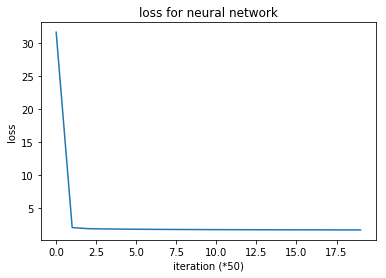

In [40]:
# the graph of loss, it decresses quickly
plt.plot(losses_nn)
plt.xlabel("iteration (*50)")
plt.ylabel("loss")
plt.title("loss for neural network")
plt.show()

In [33]:
error_nn = np.average((R_test-R_prediction)**2)

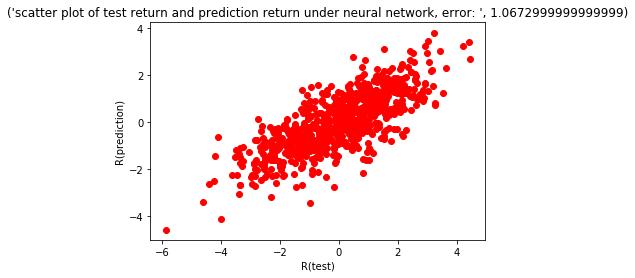

In [34]:
# this is a scatter plot of prediction and real R data, if it is a 45 degree slope, it is predicted perfectly
plt.scatter(R_test,R_prediction,c="red")
plt.xlabel("R(test)")
plt.ylabel("R(prediction)")
plt.title(("scatter plot of test return and prediction return under neural network, error: ",round(error_nn,4)))
plt.show()

## autoencoder

In [35]:
# in autoencoder, we first reduce the dimension, then we pass all reduced variables into another neural network to optimize
class AutoEncoder:
    def __init__(self,n_input,n_output =1,hidden_layer_shape=[15,10,8],regress_layer_shape = [8,8],meansquare=0,\
                 l=0,learning_rate=0.01,activation_X=tf.nn.relu,activation_Y = tf.nn.sigmoid,optimizer = tf.train.GradientDescentOptimizer):
        self.X = tf.placeholder("float", [None, n_input])
        self.Y = tf.placeholder("float", [None, n_output])
        self.hidden_layer_shape = hidden_layer_shape
        # activation_X is for Auto-encoder part, and activation_Y is for
        self.activation = activation_X
        self.weight_encoder = [0]*len(hidden_layer_shape)
        self.weight_decoder = [0]*len(hidden_layer_shape)
        self.bias_encoder = [0]*len(hidden_layer_shape)
        self.bias_decoder = [0]*len(hidden_layer_shape)
        self.regress_layer_shape = regress_layer_shape
        # build the weight of encoder and decoder
        for i in range(len(hidden_layer_shape)):
            if i==0:
                self.weight_encoder[i]=tf.Variable(tf.random_normal([n_input, hidden_layer_shape[i]]))
                self.weight_decoder[-1-i] = tf.Variable(tf.random_normal([hidden_layer_shape[i], n_input]))
                self.bias_encoder[i]= tf.Variable(tf.random_normal([hidden_layer_shape[i]]))
                self.bias_decoder[-1-i] = tf.Variable(tf.random_normal([n_input]))
            else:
                self.weight_encoder[i] = tf.Variable(tf.random_normal([hidden_layer_shape[i-1], hidden_layer_shape[i]]))
                self.weight_decoder[-1-i] = tf.Variable(tf.random_normal([hidden_layer_shape[i], hidden_layer_shape[i-1]]))
                self.bias_encoder[i] = tf.Variable(tf.random_normal([hidden_layer_shape[i]]))
                self.bias_decoder[-1-i]= tf.Variable(tf.random_normal([hidden_layer_shape[i-1]]))

        encoder_op = self.encoder()
        self.y_predict = self.predict(encoder_op,hidden_layer_shape[-1],n_output,activation_Y)
        decoder_op = self.decoder(encoder_op)
        self.x_predict=decoder_op
        self.x_true = self.X
        # mean square error loss, sometimes it works bad
        if meansquare==1:
            self.loss_X = tf.reduce_mean(tf.square(self.x_true - self.x_predict)) 
        # cross entropy error loss, sometimes it would not work for negative input/output
        elif meansquare == 0:
            self.loss_X = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(self.x_true,self.x_predict))
        self.loss_Y = tf.reduce_mean(tf.square(self.Y - self.y_predict))
        # we have a L1 regulariation for all the weight
        self.weight_encoder = np.array(self.weight_encoder)
        self.weight_decoder = np.array(self.weight_decoder)
        penalty = tf.constant(0.02)
        for i in range(len(self.weight_encoder)):
            penalty =tf.add(penalty,tf.reduce_mean(tf.abs(self.weight_encoder[i])))
            penalty = tf.add(penalty,tf.reduce_mean(tf.abs(self.weight_decoder[i])))
        self.penalty = tf.reduce_mean(penalty)
        self.loss_X = tf.add(self.loss_X,l*self.penalty)
        self.loss = tf.add(self.loss_X,self.loss_Y)
        #loss of predictions, which is equal to the loss of autoencoder part and neural network part.
        self.optimizer =  optimizer(learning_rate).minimize(self.loss)
        
    # the encoder function returns the innermost dimension-reduced features
    # the decoder function recalculate the input from these dimension-reduced features
    def encoder(self):
        for i in range(len(self.hidden_layer_shape)):
            if i==0:
                layer = self.activation(tf.add(tf.matmul(self.X, self.weight_encoder[i]),self.bias_encoder[i]))
            else:
                layer = self.activation(tf.add(tf.matmul(layer, self.weight_encoder[i]),self.bias_encoder[i]))
        return layer
    
    def decoder(self,Y):
        for i in range(len(self.hidden_layer_shape)):
            if i==0:
                layer = self.activation(tf.add(tf.matmul(Y, self.weight_decoder[i]),self.bias_decoder[i]))
            else:
                layer = self.activation(tf.add(tf.matmul(layer, self.weight_decoder[i]),self.bias_decoder[i]))
        return layer
    # this predict function uses another neural network, and this is the same with the formal one
    def predict(self,X,n_input,n_output,activation):
        previous_layer_output = X
        previous_layer_size = n_input
        regress_layer_shape_full = self.regress_layer_shape + [n_output]
        # define all layers
        for i in range(0, len(regress_layer_shape_full)):
            if i < (len(regress_layer_shape_full) - 1):
                # inner (hidden) layer
                hidden_layer = core_layers.Dense(regress_layer_shape_full[i], activation=activation)   
            else:
                # output layer
                hidden_layer = core_layers.Dense(regress_layer_shape_full[i])
                
            hidden_layer.build([None, previous_layer_size])
            
            # output of a hidden layer is an iput to the next layer
            previous_layer_output = hidden_layer(previous_layer_output)
            
            # also redefine the size of the previous layer as the size of the current layer 
            previous_layer_size = regress_layer_shape_full[i]
        return previous_layer_output


In [36]:
model_auto = AutoEncoder(n_input=F.shape[1],n_output = R.shape[1],learning_rate=0.01)  

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


In [45]:
losses_auto = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _ = sess.run(model_auto.optimizer,feed_dict={model_auto.X:F_train,model_auto.Y:R_train})
        loss = sess.run(model_auto.loss,feed_dict={model_auto.X:F_train,model_auto.Y:R_train})
        output = sess.run(model_auto.y_predict,feed_dict={model_auto.X:F_train,model_auto.Y:R_train})
        if i%50== 0:
            print(i,loss,end = " ")
            losses_auto.append(loss)
    Y_predict = sess.run(model_auto.y_predict,feed_dict={model_auto.X:F_test})

0 31.6603 50 3.20889 100 3.04936 150 2.89389 200 2.68853 250 2.47541 300 2.31656 350 2.20345 400 2.12722 450 2.07478 500 2.03544 550 2.00407 600 1.97807 650 1.95625 700 1.93806 750 1.92263 800 1.90935 850 1.89772 900 1.8875 950 1.8786 1000 1.87086 1050 1.86408 1100 1.85804 1150 1.85273 1200 1.84798 1250 1.84364 1300 1.83972 1350 1.83608 1400 1.83271 1450 1.82953 1500 1.82653 1550 1.82365 1600 1.82091 1650 1.81828 1700 1.81575 1750 1.81333 1800 1.81098 1850 1.80868 1900 1.80645 1950 1.80426 2000 1.80215 2050 1.80007 2100 1.79805 2150 1.79612 2200 1.79423 2250 1.79237 2300 1.79055 2350 1.78877 2400 1.787 2450 1.78527 2500 1.78356 2550 1.78192 2600 1.7803 2650 1.77871 2700 1.77712 2750 1.77556 2800 1.77401 2850 1.77248 2900 1.77097 2950 1.76948 3000 1.768 3050 1.76653 3100 1.76509 3150 1.76366 3200 1.76225 3250 1.76086 3300 1.75951 3350 1.75818 3400 1.75687 3450 1.75556 3500 1.75428 3550 1.75301 3600 1.75177 3650 1.75052 3700 1.74934 3750 1.74817 3800 1.74701 3850 1.74587 3900 1.74474 395

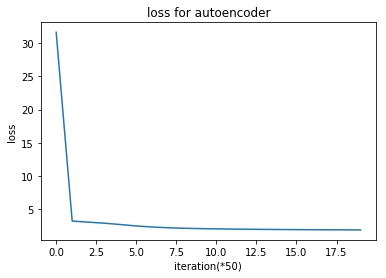

In [51]:
# the graph of loss for autoencoder, here it converge similar to regular neural network
plt.plot(losses_auto[:20])
plt.xlabel("iteration(*50)")
plt.ylabel("loss")
plt.title("loss for autoencoder")
plt.show()

In [52]:
error_auto =  np.average((R_test-Y_predict)**2)

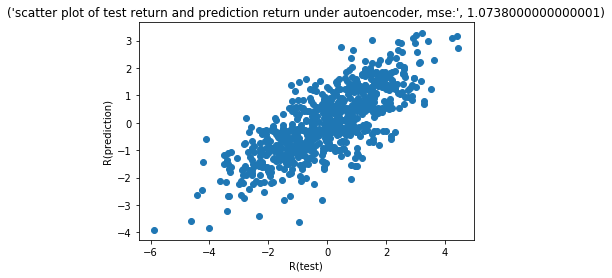

In [53]:
# this prediction is similar to that we obtained in neural network
plt.scatter(R_test,Y_predict)
plt.xlabel("R(test)")
plt.ylabel("R(prediction)")
plt.title(('scatter plot of test return and prediction return under autoencoder, mse:',round(error_auto,4)))
plt.show()

# part III: use real SP500 index data and indicators to predict trend

In [55]:
# we use 10 year data of SP500
start = datetime(2007, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2017, 11, 1, 0, 0, 0, 0, pytz.utc)
data = web.DataReader('^GSPC', 'yahoo', start, end)

In [56]:
# we calculate 23 indicators using talib, and save them into a file, you need to change path to load them
factors= pd.DataFrame.from_csv("C:/NYU/machine learning/projects/indicators_new.csv")

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  from ipykernel import kernelapp as app


In [57]:
# factor pre-processing, to remove the nas of indicators
for i in range(len(factors)):
    tmp = (factors[i:i+1]==factors[i:i+1])
    if sum(sum(tmp.values)) == len(factors.columns):
        L = i
        break

In [58]:
Data = data[:]
Factors = factors[:]

In [59]:
data = Data[L:]
close = data["Adj Close"].values
factors = Factors[L:].values

In [60]:
#log return
Return = np.diff(np.log(close))
factors = factors[:-1]

In [61]:
# we want to predict the trend, a +1/-1 signal
Return = Return.reshape(-1,1)
returns = np.sign(Return)

In [62]:
# we separate 10 year data into training sample, validation sample and testing sample with a ratio 5:1:2
n_train = int(Return.shape[0]*3/4)
n_validation = int(Return.shape[0]*1/8)
X_train = factors[:n_train-n_validation]
X_validation = factors[n_train-n_validation:n_train]
X_test = factors[n_train:]
Y_train = returns[:n_train-n_validation]
Y_validation = returns[n_train-n_validation:n_train]
Y_test = returns[n_train:]
r_validation=Return[n_train-n_validation:n_train]
r_test = Return[n_train:]

## SVM

In [63]:
class SVM():
    def __init__(self,n_input,n_output=1,learning_rate=0.001,optimizer =  tf.train.GradientDescentOptimizer):

        self.x_data = tf.placeholder(shape=[None, n_input], dtype=tf.float32)
        self.y_target = tf.placeholder(shape=[None, n_output], dtype=tf.float32)

        A = tf.Variable(tf.random_normal(shape=[n_input, n_output]))
        b = tf.Variable(tf.random_normal(shape=[n_output, n_output]))

        self.model_output = tf.subtract(tf.matmul(self.x_data, A), b)

        # Declare L2 regulariation
        l2_norm = tf.reduce_sum(tf.square(A))
        alpha = tf.constant([0.01])
        classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(self.model_output, self.y_target))))
        self.loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))
        self.prediction = tf.sign(self.model_output)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.y_target), tf.float32))
        my_opt =optimizer(learning_rate)
        self.train_step = my_opt.minimize(self.loss)
        

In [79]:
model_svm = SVM(n_input=X_train.shape[1],optimizer=tf.train.GradientDescentOptimizer,learning_rate=0.001)

In [84]:
loss_svm_training = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(50000):
        _ = sess.run(model_svm.train_step,feed_dict={model_svm.x_data:X_train,model_svm.y_target:Y_train})
        loss,Y_predict_train,accuracy_train = sess.run((model_svm.loss,model_svm.prediction,model_svm.accuracy),\
                                                       feed_dict={model_svm.x_data:X_train,model_svm.y_target:Y_train})
        if i%1000 == 0:
            print(i,loss,accuracy_train,end=" ")
            loss_svm_training.append(loss)
    Y_predict_validation_svm,accuracy_validation_svm = sess.run((model_svm.prediction,model_svm.accuracy),\
                                                    feed_dict={model_svm.x_data:X_validation,model_svm.y_target:Y_validation})    
    Y_predict_test_svm,accuracy_test_svm = sess.run((model_svm.prediction,model_svm.accuracy),\
                                                    feed_dict={model_svm.x_data:X_test,model_svm.y_target:Y_test})

0 [ 1.62789571] 0.52303 1000 [ 1.39991736] 0.532727 2000 [ 1.30011916] 0.534545 3000 [ 1.23946416] 0.54 4000 [ 1.19493151] 0.53697 5000 [ 1.15980589] 0.533333 6000 [ 1.1303885] 0.530909 7000 [ 1.10596371] 0.532727 8000 [ 1.08576953] 0.531515 9000 [ 1.06878412] 0.535152 10000 [ 1.05446124] 0.533939 11000 [ 1.04180431] 0.536364 12000 [ 1.03050339] 0.536364 13000 [ 1.02012956] 0.54303 14000 [ 1.01126683] 0.538788 15000 [ 1.00380445] 0.538788 16000 [ 0.99735141] 0.546667 17000 [ 0.99157912] 0.549697 18000 [ 0.98629552] 0.544242 19000 [ 0.98167866] 0.544242 20000 [ 0.97759819] 0.547879 21000 [ 0.97386402] 0.55697 22000 [ 0.97030467] 0.559394 23000 [ 0.96691608] 0.559394 24000 [ 0.96367013] 0.56303 25000 [ 0.9606306] 0.56303 26000 [ 0.95776469] 0.561818 27000 [ 0.95518637] 0.561818 28000 [ 0.95281714] 0.558788 29000 [ 0.9505986] 0.56 30000 [ 0.94847882] 0.561212 31000 [ 0.94651639] 0.559394 32000 [ 0.94470423] 0.559394 33000 [ 0.94296372] 0.559394 34000 [ 0.94129395] 0.561818 35000 [ 0.93970

In [90]:
print("accuracy of training sample:",accuracy_train,"accuracy of validation sample:",accuracy_validation_svm,\
      "accuracy of testing sample:",accuracy_test_svm)

accuracy of training sample: 0.552727 accuracy of validation sample: 0.536364 accuracy of testing sample: 0.534039


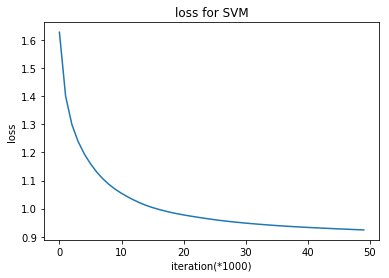

In [88]:
# loss for svm training, it converge a little slower
plt.plot(loss_svm_training)
plt.xlabel("iteration(*1000)")
plt.ylabel("loss")
plt.title("loss for SVM")
plt.show()

In [85]:
# long if output is 1, short if output is -1
pnl_svm_validation = Y_predict_validation_svm*r_validation
pnl_svm_test = Y_predict_test_svm*r_test

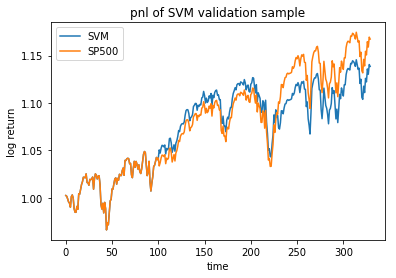

In [86]:
#plt.plot(np.exp(np.cumsum(pnl_validation)))
plt.plot(np.exp(np.cumsum(pnl_svm_validation)))
plt.plot(np.exp(np.cumsum(r_validation)))
plt.legend(("SVM","SP500"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("pnl of SVM validation sample")
plt.show()

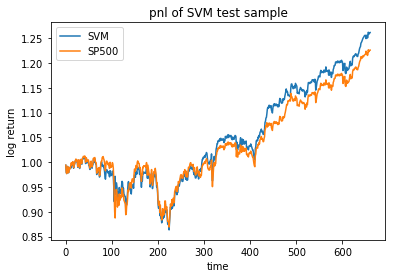

In [87]:
plt.plot(np.exp(np.cumsum(pnl_svm_test)))
plt.plot(np.exp(np.cumsum(r_test)))
plt.legend(("SVM","SP500"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("pnl of SVM test sample")
plt.show()

## autoencoder+svm

In [93]:
# this is similar to the formal Autoencoder part, and it differs for the regression of its innormost hidden layer to predicted trend
class AutoEncoder_svm:
    def __init__(self,n_input,n_output =1,hidden_layer_shape=[15,10,8],meansquare=0,\
                 l=0,learning_rate=0.01,activation_X=tf.nn.relu,activation_Y = tf.nn.sigmoid,optimizer = tf.train.AdamOptimizer):
        self.X = tf.placeholder("float", [None, n_input])
        self.Y = tf.placeholder("float", [None, n_output])
        self.hidden_layer_shape = hidden_layer_shape
        self.activation = activation_X
        self.weight_encoder = [0]*len(hidden_layer_shape)
        self.weight_decoder = [0]*len(hidden_layer_shape)
        self.bias_encoder = [0]*len(hidden_layer_shape)
        self.bias_decoder = [0]*len(hidden_layer_shape)
        
        for i in range(len(hidden_layer_shape)):
            if i==0:
                self.weight_encoder[i]=tf.Variable(tf.random_normal([n_input, hidden_layer_shape[i]]))
                self.weight_decoder[-1-i] = tf.Variable(tf.random_normal([hidden_layer_shape[i], n_input]))
                self.bias_encoder[i]= tf.Variable(tf.random_normal([hidden_layer_shape[i]]))
                self.bias_decoder[-1-i] = tf.Variable(tf.random_normal([n_input]))
            else:
                self.weight_encoder[i] = tf.Variable(tf.random_normal([hidden_layer_shape[i-1], hidden_layer_shape[i]]))
                self.weight_decoder[-1-i] = tf.Variable(tf.random_normal([hidden_layer_shape[i], hidden_layer_shape[i-1]]))
                self.bias_encoder[i] = tf.Variable(tf.random_normal([hidden_layer_shape[i]]))
                self.bias_decoder[-1-i]= tf.Variable(tf.random_normal([hidden_layer_shape[i-1]]))

        encoder_op = self.encoder()
        decoder_op = self.decoder(encoder_op)
        self.x_predict=decoder_op
        self.x_true = self.X
        # mean square error 
        if meansquare==1:
            self.loss_X = tf.reduce_mean(tf.square(self.x_true - self.x_predict)) 
        # cross entropy error
        elif meansquare == 0:
            self.loss_X = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(self.x_true,self.x_predict))
            
        ##SVM part
        A = tf.Variable(tf.random_normal(shape=[hidden_layer_shape[-1], n_output]))
        b = tf.Variable(tf.random_normal(shape=[n_output, n_output]))

        self.model_output = tf.subtract(tf.matmul(encoder_op, A), b)

        l2_norm = tf.reduce_sum(tf.square(A))
        alpha = tf.constant([0.01])
        classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1., tf.multiply(self.model_output, self.Y))))
        self.loss_Y = tf.add(classification_term, tf.multiply(alpha, l2_norm))
        # Declare prediction function, which returns +1/-1
        self.prediction = tf.sign(self.model_output)
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.prediction, self.Y), tf.float32))
        # a L1 penalty
        self.weight_encoder = np.array(self.weight_encoder)
        self.weight_decoder = np.array(self.weight_decoder)
        penalty = tf.constant(0.02)
        for i in range(len(self.weight_encoder)):
            penalty =tf.add(penalty,tf.reduce_mean(tf.abs(self.weight_encoder[i])))
            penalty = tf.add(penalty,tf.reduce_mean(tf.abs(self.weight_decoder[i])))
        self.penalty = tf.reduce_mean(penalty)
        #loss of predictions, which is equal to the loss of autoencoder part, loss of SVM part and regulariation part
        self.loss_X = tf.add(self.loss_X,l*self.penalty)
        self.loss = tf.add(self.loss_X,self.loss_Y)
        
        self.optimizer =  optimizer(learning_rate).minimize(self.loss)
        
    def encoder(self):
        for i in range(len(self.hidden_layer_shape)):
            if i==0:
                layer = self.activation(tf.add(tf.matmul(self.X, self.weight_encoder[i]),self.bias_encoder[i]))
            else:
                layer = self.activation(tf.add(tf.matmul(layer, self.weight_encoder[i]),self.bias_encoder[i]))
        return layer
    
    def decoder(self,Y):
        for i in range(len(self.hidden_layer_shape)):
            if i==0:
                layer = self.activation(tf.add(tf.matmul(Y, self.weight_decoder[i]),self.bias_decoder[i]))
            else:
                layer = self.activation(tf.add(tf.matmul(layer, self.weight_decoder[i]),self.bias_decoder[i]))
        return layer


In [115]:
model_autosvm =  AutoEncoder_svm(n_input=X_train.shape[1],hidden_layer_shape=[23,15,10],\
                      learning_rate=0.001,activation_X = tf.nn.sigmoid,l=0.02,optimizer=tf.train.AdamOptimizer,meansquare=1)

In [135]:
# this iteration would take a little time
losses_auto_svm = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        _ = sess.run(model_autosvm.optimizer,feed_dict={model_autosvm.X:X_train,model_autosvm.Y:Y_train})
        loss,Y_predict_train,accuracy_train = sess.run((model_autosvm.loss,model_autosvm.prediction,model_autosvm.accuracy),\
                                                       feed_dict={model_autosvm.X:X_train,model_autosvm.Y:Y_train})
        if i%1000 == 0:
            print(i,loss,accuracy_train,end=" ")
            losses_auto_svm.append(loss)
    Y_predict_validation,accuracy_validation = sess.run((model_autosvm.prediction,model_autosvm.accuracy),\
                                            feed_dict={model_autosvm.X:X_validation,model_autosvm.Y:Y_validation})            
    Y_predict_test,accuracy_test = sess.run((model_autosvm.prediction,model_autosvm.accuracy),\
                                            feed_dict={model_autosvm.X:X_test,model_autosvm.Y:Y_test})

0 [ 3.73796225] 0.452121 1000 [ 1.53829694] 0.572727 2000 [ 1.38068593] 0.618788 3000 [ 1.20251024] 0.69697 4000 [ 1.10766625] 0.732121 5000 [ 1.04741049] 0.752121 6000 [ 0.99966776] 0.770909 7000 [ 0.96645427] 0.778788 8000 [ 0.94065881] 0.784242 9000 [ 0.92449266] 0.788485 

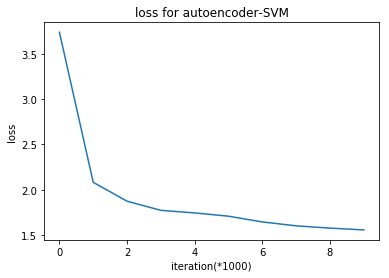

In [131]:
# loss for training sample with autoencoder with svm method
plt.plot(losses_auto_svm)
plt.xlabel("iteration(*1000)")
plt.ylabel("loss")
plt.title("loss for autoencoder-SVM")
plt.show()

In [132]:
pnl_validation_autosvm = r_validation*Y_predict_validation
pnl_test_autosvm = r_test*Y_predict_test

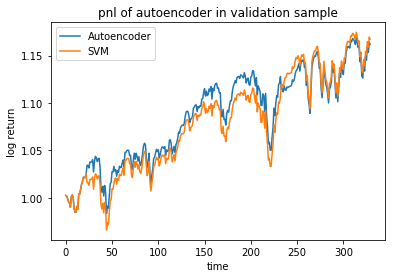

In [133]:
# autoencoder with svm method is not very stable, sometimes it would give a good result, sometimes it could not
plt.plot(np.exp(np.cumsum(pnl_validation_autosvm)))
plt.plot(np.exp(np.cumsum(r_validation)))
plt.legend(("Autoencoder","SVM","SP500"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("pnl of autoencoder in validation sample")
plt.show()

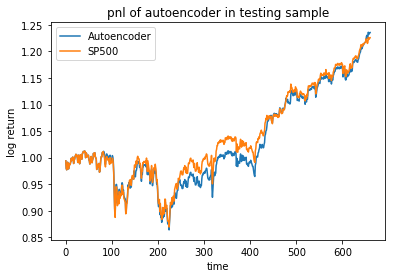

In [134]:
plt.plot(np.exp(np.cumsum(pnl_test_autosvm)))
plt.plot(np.exp(np.cumsum(r_test)))
plt.legend(("Autoencoder","SP500"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("pnl of autoencoder in testing sample")
plt.show()

## graph to compare SP500, SVM method, Autoencoder-SVM method

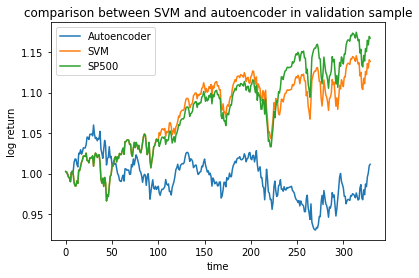

In [128]:
plt.plot(np.exp(np.cumsum(pnl_validation_autosvm)))
plt.plot(np.exp(np.cumsum(pnl_svm_validation)))
plt.plot(np.exp(np.cumsum(r_validation)))
plt.legend(("Autoencoder","SVM","SP500"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("comparison between SVM and autoencoder in validation sample")
plt.show()

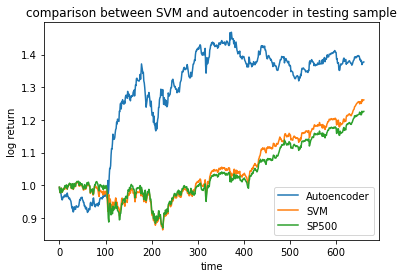

In [129]:
plt.plot(np.exp(np.cumsum(pnl_test_autosvm)))
plt.plot(np.exp(np.cumsum(pnl_svm_test)))
plt.plot(np.exp(np.cumsum(r_test)))
plt.legend(("Autoencoder","SVM","SP500"))
plt.xlabel("time")
plt.ylabel("log return")
plt.title("comparison between SVM and autoencoder in testing sample")
plt.show()